In [16]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import sys
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnn as qcnn
import visualization as qplt
import encoder as enc
import losses

In [2]:
path = '../data/vqes/ANNNI/'

In [3]:
N = 12
side = 50


In [9]:
myvqe = vqe.load_vqe(path+'N'+str(N)+'n'+str(side))

In [10]:
myvqe.MSE0 = [0]

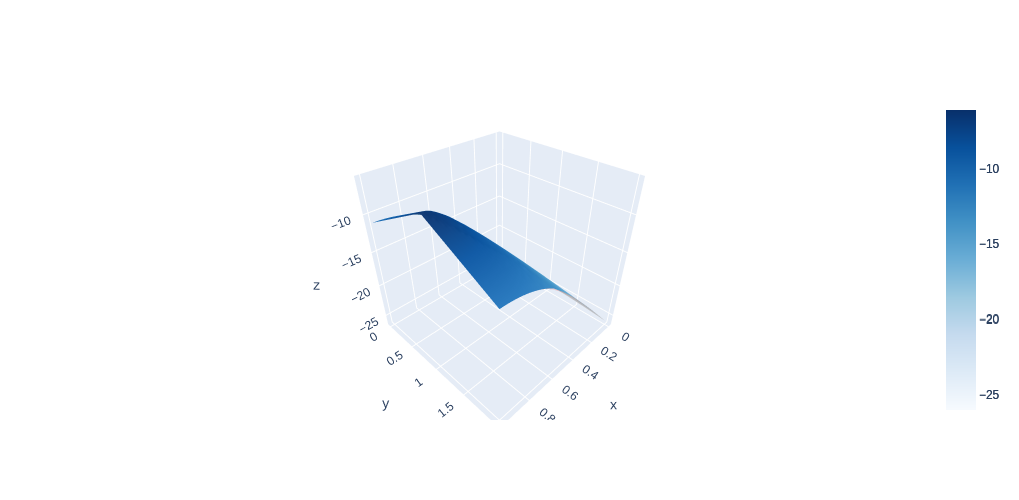

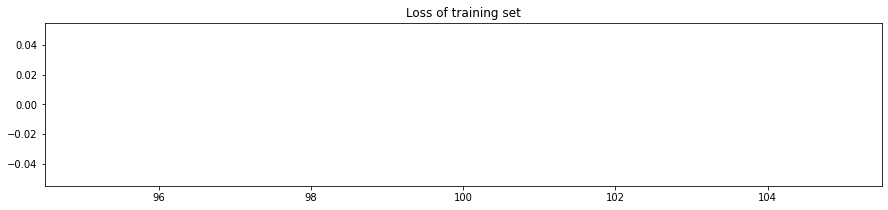

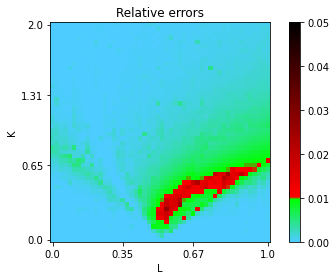

In [11]:
qplt.show_VQE_annni(myvqe)

In [13]:
myqcnn = qcnn.qcnn(myvqe, qcnn.qcnn_circuit, n_outputs = 2)

In [14]:
train_index = np.arange(0,2*side-1)

In [18]:
myqcnn.train(.25, 1000, train_index, losses.cross_entropy_multiclass, circuit=True)

+--- CIRCUIT ---+
 0: ──||──||──RY(0.00)───RX(12.00)──||──RY(24.00)─────||──RY(30.00)─╭C──RY(37.00)──||
 1: ──||──||──RY(1.00)───RX(13.00)──||──RY(24.00)─╭C──||──RY(31.00)─╰X──RY(38.00)──||
 2: ──||──||──RY(2.00)───RX(14.00)──||──RY(25.00)─╰X──||──RY(31.00)─╭C──RY(39.00)──||
 3: ──||──||──RY(3.00)───RX(15.00)──||──RY(25.00)─╭C──||──RY(32.00)─╰X──RY(40.00)──||
 4: ──||──||──RY(4.00)───RX(16.00)──||──RY(26.00)─╰X──||──RY(32.00)─╭C──RY(41.00)──||
 5: ──||──||──RY(5.00)───RX(17.00)──||──RY(26.00)─╭C──||──RY(33.00)─╰X──RY(42.00)──||
 6: ──||──||──RY(6.00)───RX(18.00)──||──RY(27.00)─╰X──||──RY(33.00)─╭C──RY(43.00)──||
 7: ──||──||──RY(7.00)───RX(19.00)──||──RY(27.00)─╭C──||──RY(34.00)─╰X──RY(44.00)──||
 8: ──||──||──RY(8.00)───RX(20.00)──||──RY(28.00)─╰X──||──RY(34.00)─╭C──RY(45.00)──||
 9: ──||──||──RY(9.00)───RX(21.00)──||──RY(28.00)─╭C──||──RY(35.00)─╰X──RY(46.00)──||
10: ──||──||──RY(10.00)──RX(22.00)──||──RY(29.00)─╰X──||──RY(35.00)─╭C──RY(47.00)──||
11: ──||──||──RY(11.00)──RX(23.00)──

Cost: 0.0729290246963501: 100%|█████████████| 1000/1000 [03:14<00:00,  5.15it/s]


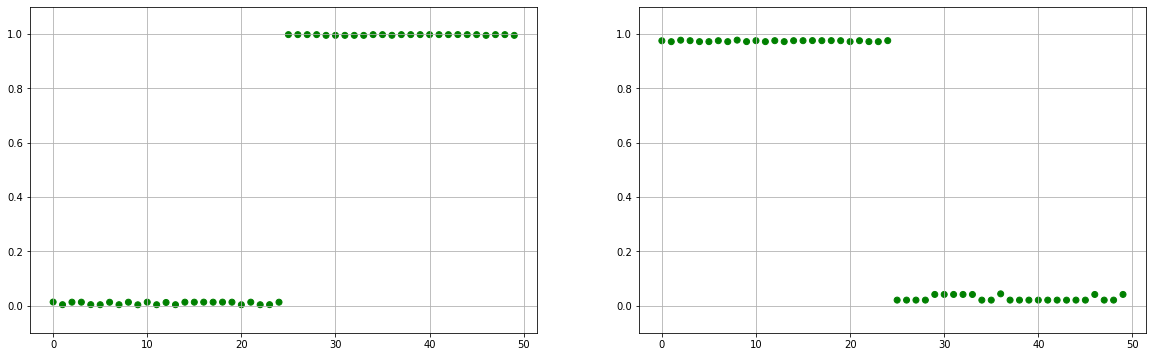

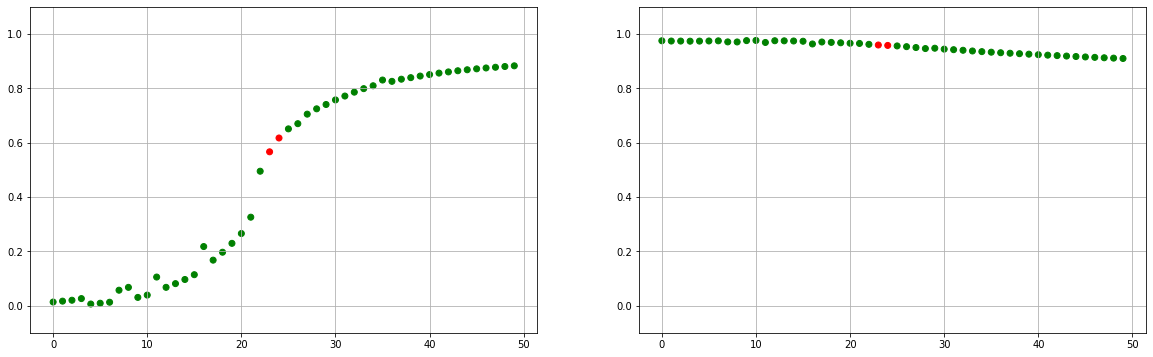

In [19]:
qplt.show_QCNN_classification2D(myqcnn)

In [60]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
import plotly.graph_objects as go
import pandas as pd
from orqviz.scans import perform_2D_scan, plot_2D_scan_result
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

def show_QCNN_classificationANNNI(qcnnclass, hard_thr = True, lines = False):
    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        circuit(params_vqe, params)

        if qcnnclass.n_outputs == 1:
            return qml.probs(wires=self.N - 1)
        else:
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))

    if hard_thr:
        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))
        c = []
        for pred in predictions:
            if (pred == [0,1]).all():
                c.append(0)
            elif (pred == [1,1]).all():
                c.append(1)
            elif (pred == [1,0]).all():
                c.append(2)
            else: c.append(3)

        phases = mpl.colors.ListedColormap(["skyblue", "lightsalmon", "black", "palegreen"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,4), phases.N) 
        plt.imshow( np.rot90(np.reshape(c, (side, side) )), 
                                      cmap = phases, norm = norm)
    else:
        predictions = np.array(vcircuit(qcnnclass.vqe_params) )
        c = []
        
        # define color map 
        color_map = {1: np.array([255, 0, 0]), # red
                     2: np.array([0, 255, 0]), # green
                     3: np.array([0, 0, 255])} # blue
        
        rgb_probs = np.ndarray(shape=(side*side, 3), dtype=float)
        
        for i, pred in enumerate(predictions):
            p0 = 1 - np.sum(np.abs(pred[:,0] - [0,1]))/2
            p1 = 1 - np.sum(np.abs(pred[:,0] - [1,1]))/2
            p2 = 1 - np.sum(np.abs(pred[:,0] - [1,0]))/2
            
            rgb_probs[i] = [p0*255,p1*255,p2*255]
        print(rgb_probs)
        rgb_probs = np.rot90(np.reshape(rgb_probs, (side,side,3)) )/255
        
        plt.imshow( rgb_probs )
        
    plt.title('Classification of ANNNI states')
    plt.ylabel('L')
    plt.xlabel('K')
    
    def getlines(func, xrange, side, color, res = 100):
        xs = np.linspace(xrange[0], xrange[1], res)
        ys = func(xs)
        
        plt.plot(side*xs -.5, side - ys*side/2 -.5, color = color)
        
    def B2SA(x):
        return 1.05 * np.sqrt((x-.5)*(x-.1))
    
    def ferropara(x):
        return 1 - 2*x
                     
    getlines(ferropara, [0,.5], side, 'darkviolet', res = 100)
    getlines(B2SA, [.5,1], side, 'blue', res = 100)
    
    plt.show()

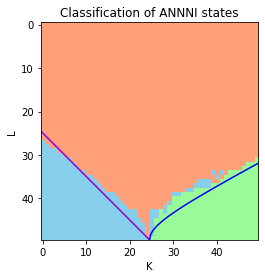

In [61]:
_ = show_QCNN_classificationANNNI(myqcnn, hard_thr = True)

[[  4.94585498 129.0686874  250.05414502]
 [  5.48862142 128.78358466 249.51137858]
 [  5.92594233 128.37452379 249.07405767]
 ...
 [131.88681711  35.40870588 123.11318289]
 [131.66743018  35.33499934 123.33256982]
 [131.63637349  35.15882274 123.36362651]]


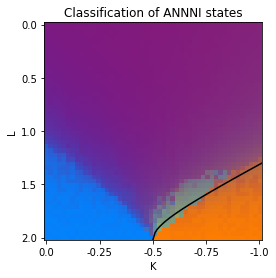

In [33]:
_ = show_QCNN_classificationANNNI(myqcnn, hard_thr = False)